# Seattle Airbnb dataset analysis

In this notebook, we look at the data provided by Airbnb for their listings in Seattle. We follow CRISP-DM in order to answer the busines questions outlined in the section below

## 1. Business understanding

Airbnb serves guests and hosts whether to list a property or find one that match their need. Given the provided data, business would like to have the following three questions ansered:
- Is there any trend in house prices and availability, and how can it be explained?
- Can we estimate the price of a listing given listing features?
- Does the cancellation policy affect occupancy of the property?

## 2. data understanding
The data consists of three data sets ([Source](https://www.kaggle.com/airbnb/seattle/data)):

- __Listings__, including full descriptions and average review score
- __Reviews__, including unique id for each reviewer and detailed comments
- __Calendar__, including listing id and the price and availability for that day


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
# Load datasets
calendar = pd.read_csv('./calendar.csv')
listings = pd.read_csv('./listings.csv')
reviews = pd.read_csv('./reviews.csv')

In [3]:
# helper functions
def df_summary(df):
    '''
    Prints the shape, missing percentages of columns and the head of a dataframe

            Parameters:
                    df (pandas.Dataframe): The dataframe to show the summary for
    '''
    print('- Shape:')
    print(df.shape)
    print('- Missing:')
    print(df.isna().mean()[df.isna().mean()>0])
    display(df.head())

### We look at the head of each of the three data failes, how they look and if there is any missing values

In [4]:
df_summary(calendar)

- Shape:
(1393570, 4)
- Missing:
price    0.32939
dtype: float64


,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


##### For calendar dataset, It seems we have the availability for each day of 365 days, for 3818 properties. The missing price is only for the property on unlisted days, so that should not be a problem

In [5]:
df_summary(listings)

- Shape:
(3818, 92)
- Missing:
summary                        0.046359
space                          0.149031
neighborhood_overview          0.270299
notes                          0.420639
transit                        0.244631
thumbnail_url                  0.083814
medium_url                     0.083814
xl_picture_url                 0.083814
host_name                      0.000524
host_since                     0.000524
host_location                  0.002095
host_about                     0.224987
host_response_time             0.136983
host_response_rate             0.136983
host_acceptance_rate           0.202462
host_is_superhost              0.000524
host_thumbnail_url             0.000524
host_picture_url               0.000524
host_neighbourhood             0.078575
host_listings_count            0.000524
host_total_listings_count      0.000524
host_has_profile_pic           0.000524
host_identity_verified         0.000524
neighbourhood                  0.108958
zipcode  

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

##### For listings dataset, clearly we have 3818 properties. The columns contain information about the the description of the property itself, links to different resources, host details, geographical infromation, review scores for different categories, and renting conditions.

##### We can see that multiple columns have a high missing percentage, which we will deal with in the next section. Also there are multiple textual columns that we could replace with a flag of whether e.g. a description exists or not. The next section will deal also with the categorical features that exist in the dataset

In [6]:
df_summary(reviews)

- Shape:
(84849, 6)
- Missing:
comments    0.000212
dtype: float64


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


##### The data above has almost no missing values and have clear columns

## 2. data preparation
In this section we will perform the following data processing steps on each dataset:
- calendar:
    - Convert 'date' column to datetime type
    - Replace 't' and 'f' values with 1 and 0 accordingly
    - Convert the price into a numeric
    - Add a column 'is_weekend' highlighting whether the night following that date is a weekend or not. That's why we are specifying ['Friday', 'Saturday']


In [7]:
def prepare_calendar_dataset(calendar):
    '''
    Performs all cleansing steps for the calendar dataset:
        - Convert 'date' column to datetime type
        - Replace 't' and 'f' values with 1 and 0 accordingly
        - Convert the price into a numeric
        - Add a column 'is_weekend' highlighting whether the night following that date is a weekend or not. That's why we are specifying ['Friday', 'Saturday']

            Parameters:
                    calendar (pandas.DataFrame): calendar dataframe

            Returns:
                    calendar (pandas.DataFrame): calendar dataframe after performing all preparations steps
    '''
    calendar.available = calendar.available.replace({'t': 1, 'f': 0})
    calendar.price = calendar.price.str.replace('[\$,]', '', regex=True).astype(float)
    calendar.date = pd.to_datetime(calendar.date)
    calendar['is_weekend'] = calendar.date.dt.day_name().isin(['Friday', 'Saturday'])*1
    return calendar

# Prepare calendar dataset
calendar = prepare_calendar_dataset(calendar)

- listings:
    - Drop columns where missing values is above 20%
    - Remove features that will not contribute much to our analysis such as scrape details, some host details, or are very detailed for the scope of this analysis, such detailed geographical information other than the neighborhood. Also, some data which might leak some information into the model in the modelling part such as the mnthly or weekly rates. The features that will be removed are: 
    
    `'listing_url', 'scrape_id', 'last_scraped', 'name',
       'experiences_offered', 'host_id', 'host_url', 'host_name',
       'host_location', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count', 'neighbourhood_cleansed',
       'host_total_listings_count', 'host_verifications', 'street',
       'neighbourhood', 'city', 'state', 'zipcode', 'market', 'smart_location',
       'country_code', 'country', 'latitude', 'longitude', 'is_location_exact',
       'amenities', 'extra_people', 'minimum_nights', 'maximum_nights',
       'calendar_updated', 'has_availability', 'availability_30',
       'availability_60', 'availability_90', 'availability_365',
       'calendar_last_scraped', 'first_review', 'last_review',
       'requires_license', 'jurisdiction_names', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count', 'reviews_per_month'`
    - Set id as index and rename it to 'listing_id'
    - Convert descriptive columns to a flag of whether there is an entry for it or not (0 or 1)
    - Convert host since to a number from the date year to 2016 where our data is
    - Convert columns with 't' and 'f' values to 1 and 0 accordingly
    - Convert rates and scores to a percentage value from 0 to 1
    - Create one hot encoding dummies for categorical features for ease of modelling
    - Convert price to a numeric value
    - Add feature 'availability' which is the percentage of days the property was available during the year

In [8]:
def prepare_listings_dataset(listings):
    '''
    Performs all cleansing steps for the listings dataset:
        - Drop columns with missing values above 20%
        - Remove irrelevant features
        - Fix data types for binary, ratios and percentages
        - One hot encode categorical features

            Parameters:
                    listings (pandas.DataFrame): listings dataframe

            Returns:
                    listings (pandas.DataFrame): listings dataframe after performing all preparations steps
    '''
    listings = pd.read_csv('./listings.csv')
    
    # Drop columns where missing values is above 20% and Remove features that will not contribute to the analysis
    listings = listings[listings.columns[listings.isna().mean()<0.2]]
    listings = listings[listings.columns[~listings.columns.isin(['listing_url', 'scrape_id', 'last_scraped', 'name',
                         'experiences_offered', 'host_id', 'host_url', 'host_name',
                         'host_location', 'host_thumbnail_url', 'host_picture_url',
                         'host_neighbourhood', 'host_listings_count', 'neighbourhood_cleansed', 
                         'host_total_listings_count', 'host_verifications', 'street',
                         'neighbourhood', 'city', 'state', 'zipcode', 'market', 'smart_location',
                         'country_code', 'country', 'latitude', 'longitude', 'is_location_exact',
                         'amenities', 'extra_people', 'minimum_nights', 'maximum_nights',
                         'calendar_updated', 'has_availability', 'availability_30',
                         'availability_60', 'availability_90', 'availability_365',
                         'calendar_last_scraped', 'first_review', 'last_review',
                         'requires_license', 'jurisdiction_names', 'instant_bookable',
                         'require_guest_profile_picture', 'require_guest_phone_verification',
                         'calculated_host_listings_count', 'reviews_per_month'])]]
    listings = listings.rename(columns={'id':'listing_id'})
    listings = listings.set_index('listing_id')
    
    # Convert descriptive columns to a flag of whether there is an entry for it or not (0 or 1)
    listings[['summary',
             'space',
             'description',
             'thumbnail_url',
             'medium_url',
             'picture_url',
             'xl_picture_url']] = ~listings[['summary',
             'space',
             'description',
             'thumbnail_url',
             'medium_url',
             'picture_url',
             'xl_picture_url']].isna()*1
    
    # Convert host since to a number from the date year to 2016 where our data is
    listings.host_since = 2016 - pd.to_datetime(listings.host_since).dt.year
    
    # Convert columns with 't' and 'f' values to 1 and 0 accordingly
    listings.host_is_superhost = listings.host_is_superhost.replace({'t': 1, 'f': 0})
    listings.host_has_profile_pic = listings.host_has_profile_pic.replace({'t': 1, 'f': 0})
    listings.host_identity_verified = listings.host_identity_verified.replace({'t': 1, 'f': 0})
    
    # Convert rates and scores to a percentage value from 0 to 1
    listings.host_response_rate = listings.host_response_rate.str.replace('[\%]', '', regex=True).astype(float)/100
    listings.review_scores_rating = listings.review_scores_rating/100
    listings.review_scores_accuracy = listings.review_scores_accuracy/10
    listings.review_scores_cleanliness = listings.review_scores_cleanliness/10
    listings.review_scores_checkin = listings.review_scores_checkin/10
    listings.review_scores_communication = listings.review_scores_communication/10
    listings.review_scores_location = listings.review_scores_location/10
    listings.review_scores_value = listings.review_scores_value/10
    
    # Create one hot encoding dummies for categorical features for ease of modelling
    listings = listings.merge(pd.get_dummies(listings.host_response_time), on='listing_id')
    listings = listings.merge(pd.get_dummies(listings.neighbourhood_group_cleansed), on='listing_id')
    listings = listings.merge(pd.get_dummies(listings.property_type), on='listing_id')
    listings = listings.merge(pd.get_dummies(listings.room_type), on='listing_id')
    listings = listings.merge(pd.get_dummies(listings.bed_type), on='listing_id')
    listings = listings.merge(pd.get_dummies(listings.cancellation_policy), on='listing_id')
    listings = listings.drop('host_response_time', axis=1)
    listings = listings.drop('neighbourhood_group_cleansed', axis=1)
    listings = listings.drop('property_type', axis=1)
    listings = listings.drop('room_type', axis=1)
    listings = listings.drop('bed_type', axis=1)
    listings = listings.drop('cancellation_policy', axis=1)
    
    # Convert price to a numeric value
    listings.price = listings.price.str.replace('[\$,]', '', regex=True).astype(float)

    # Add feature 'availability' which is the percentage of days the property was available during the year
    listings = listings.merge(calendar.groupby('listing_id').available.mean(), on='listing_id')
    listings = listings.rename(columns={'available':'availability'})
    
    # Fill the remaining missing values with 0
    listings = listings.fillna(0)
    
    return listings

# Prepare listings dataset    
listings = prepare_listings_dataset(listings)

## 3. Data analysis, modelling, and evaluation
In this section we use the data to answer the business questions:

### *Q1 - __Is there any trend in house prices and availability, and how can it be explained?__*

To answer this question and the next actually, we will look at the distribution of 'price' feature in actual listings  and check if there are outliers

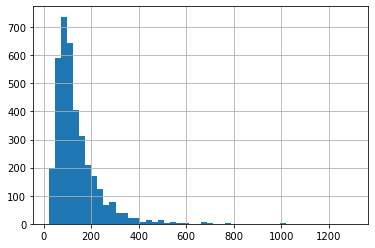

count    3723.000000
mean      135.764060
std        97.385682
min        20.000000
25%        75.629042
50%       108.416107
75%       162.099432
max      1301.818182
Name: price, dtype: float64

In [9]:
calendar.groupby('listing_id').price.mean().hist(bins=50)
plt.show()
display(calendar.groupby('listing_id').price.mean().describe())

We can see that the data is skewed to the right, and there might be some outliers there. Therefore, we will display a boxplot to see if it shows some outlier values

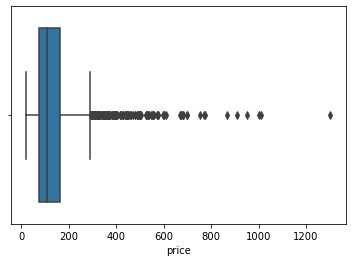

In [10]:
sb.boxplot(x = calendar.groupby('listing_id').price.mean(), showfliers=True)
plt.show()

We can see that there are some outlier values above around 290~300. However, we will not deal with those at the moment, but in the next question. Those values are around 200 listings

Then we create an aggregation of calendar dataframe 'agg_calendar'. It will calculate:
- __mean_price__: mean listings price for each day
- __total_available__: number of available units for each day
- __available_percentage__: percentage of available units for each day

In [11]:
def create_agg_calendar(calendar):
    '''
    Create an aggregation dataframe for the calendar dataframe:
        - mean_price: mean listings price for each day
        - total_available: number of available units for each day
        - available_percentage: percentage of available units for each day


            Parameters:
                    calendar (pandas.DataFrame): calendar dataframe

            Returns:
                    agg_calendar (pandas.DataFrame): aggregated calendar dataframe
    '''
    agg_calendar = pd.DataFrame({'mean_price': calendar.groupby('date').price.mean()})
    agg_calendar['total_available'] = calendar.groupby('date').available.sum()
    agg_calendar = agg_calendar.merge(calendar[['date', 'is_weekend']].drop_duplicates(),on='date')
    return agg_calendar

# Create aggregated calendar dataframe
agg_calendar = create_agg_calendar(calendar)

##### Number of available listings daily

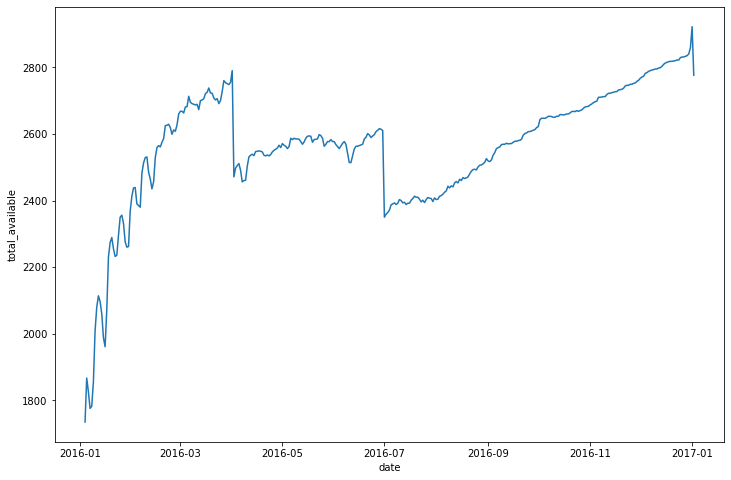

In [12]:
# Plot number of available listings daily
fig = plt.gcf()
fig.set_size_inches(12, 8)
sb.lineplot(data=agg_calendar, x='date', y='total_available')
plt.show()

From the plot above we can make the following observations:
- There is an overall positive trend in units availability throughout the year
- We see two main dips in availability one is around April, and the other is around July
- The dips can be attributed to spring break and summer time accordingly. However, spring break lasts for around a week to 10 days, so it is interesting why we did not see a spike back up by end of the summer break
- The zigzag pattern in the plot seems to correspond with weekends. This will explored further in the next charts as it highlights the effect of the weekend better

Next we can look at the price change over time

##### Mean listings price daily

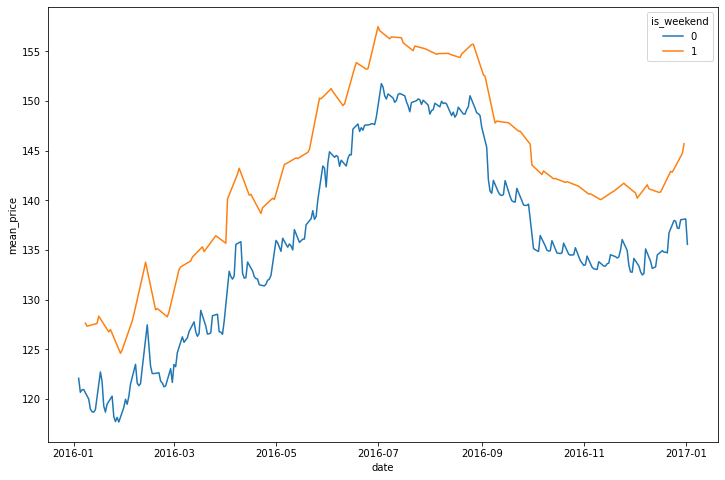

In [13]:
# Plot mean listings price daily
fig = plt.gcf()
fig.set_size_inches(12, 8)
sb.lineplot(data=agg_calendar, x='date', y='mean_price', hue='is_weekend')
plt.show()

We can make the following observations from the chart above:
- There is a price increase trend from the beginning of the yar till around July
- Prices remain relatively stable until around September, which is near the end of summer break, then drop quickly
- At any point of time, weekend rates are higher by about 5%
- We still can still see a spike in prices near spring break 
- However, There are two more spikes one smal near the new year, and the other is significant and is around mid Feb, which is most probably around Valntine's time

### *Q2 - __Can we estimate the price of a listing given listing features?__*

We will use the features that we have curated earlier in order to predict the price of a unit. However, we will use the mean price from the calendar to predict because it is more reflective of actual prices. We will only rely on price from listings when the value is missing from the calendar

In [14]:
def prepare_data_for_model(listings, calendar):
    '''
    Prepares the dataset for modelling by removing price otliers, 
    using the aggregated price from the calendar, and splitting the dataset

            Parameters:
                    listings (pandas.DataFrame): listings dataframe
                    calendar (pandas.DataFrame): calendar dataframe

            Returns:
                    x_train (pandas.DataFrame): training set features
                    x_test (pandas.DataFrame): testing set features
                    y_train (pandas.Series): training set labels
                    y_test (pandas.Series): testing set labels
    '''
    calendar = calendar[calendar.price < 395]
    actual_prices = calendar.groupby('listing_id').price.mean()
    actual_prices = actual_prices.fillna(listings.price)

    listings = listings.drop('price', axis=1)
    listings = listings.merge(actual_prices, on='listing_id')

    y = listings.price
    x = listings.drop(['price'], axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
    return x_train, x_test, y_train, y_test

In [15]:
# Get the prepared data for modelling
x_train, x_test, y_train, y_test = prepare_data_for_model(listings, calendar)

We will randomized search in order to help us select an optimal set of parameters for our model. Randomized search will not brute force all possible combinations in the same manner that grid search works, so it should relatively have a better performance. Also, with cross-validation, it will ensure that the model will generalize better

In [16]:
def build_model():
    '''
    Build a random forest regression model and use randomized search cv to find the best model prameters

            Returns:
                    rf_random (RandomizedSearchCV): the model enveloped in the search method
    '''
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]# Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    # Define the random forest model and set it in randomized search cv
    rfr = RandomForestRegressor()
    rf_random = RandomizedSearchCV(estimator = rfr, param_distributions = random_grid, 
                                   n_iter = 150, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    return rf_random

In [17]:
def display_model_metrics(y_test, y_pred, model):
    '''
    Displays the model metrics (r2_score, MAE), and the best performing model metrics

            Parameters:
                    y_test (pandas.Series): ground truth values
                    y_pred (pandas.Series): model predictions
                    model (RandomizedSearchCV): fit search model 
    '''
    print('r2_score: ', r2_score(y_test, y_pred))
    print('MAE: ', mean_absolute_error(y_test, y_pred))
    print('Best performing model parameters:')
    print(rf_random.best_params_)

In [18]:
rf_random = build_model()
rf_random.fit(x_train, y_train)
y_pred = rf_random.predict(x_test)
display_model_metrics(y_test, y_pred, rf_random)

Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 450 out of 450 | elapsed: 18.2min finished


r2_score:  0.6896919180862899
MAE:  27.76303825328327
Best performing model parameters:
{'n_estimators': 1600, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 70, 'bootstrap': False}


We can see that the model's prformance is not ideal with R2 score of around 0.68, but it indicates that some features are actually contributing to the model's output. Now let's look at the features that were most important to the model to make its predictions, and how they are correlated:

### *Q3 - __What are the factors determining the price of a listing?__*

We start this by: 
- looking at the most important features determined by the model
- then we look at the correlation of each features
- finally we look at a scatterplot matrix to infer more details about distributions

In [19]:
# get the top 10 most important features determined by the model
features_imp = dict(zip(x_train.columns, rf_random.best_estimator_.feature_importances_))
top_10_features_imp = dict(sorted(features_imp.items(), key=lambda x: x[1], reverse=True)[:10])
top_10_features_imp

{'bedrooms': 0.14345301211139896,
 'accommodates': 0.13075249581543014,
 'Entire home/apt': 0.09155648497425613,
 'bathrooms': 0.08180777289218852,
 'beds': 0.0774950562520881,
 'Private room': 0.05630753438277342,
 'guests_included': 0.04063099353309295,
 'availability': 0.037727848411964304,
 'Downtown': 0.027774449193122858,
 'number_of_reviews': 0.026207894940509527}

Clearly the most important features to determine a property's price are its size and how many it accomodates. Also, the listing type, the level of availability and how much it was reviewed all contribute to its price.

Now let's look at how those features are correlated with price and with each other. However, we will limit it only to 5 features for ease of visualization:

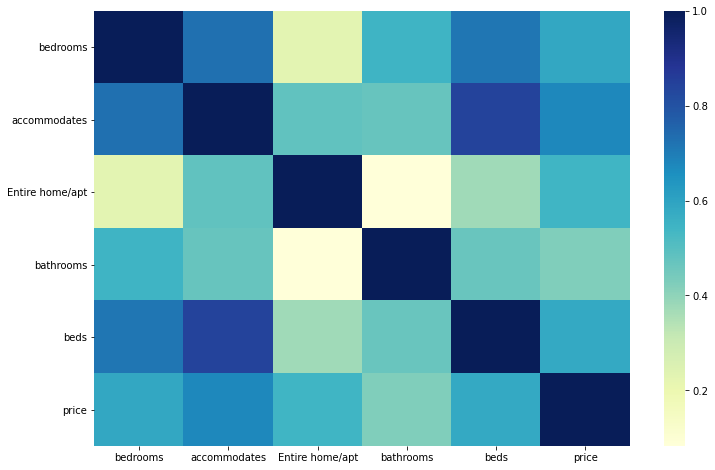

In [20]:
# Display correlation matrix for the top 5 features with price
fig = plt.gcf()
fig.set_size_inches(12, 8)
top_features_df = pd.concat([x_train, x_test], axis=0)[list(top_10_features_imp.keys())[:5]]
top_features_df = top_features_df.merge(pd.concat([y_train, y_test], axis=0), on='listing_id')

sb.heatmap(pd.DataFrame.corr(top_features_df), cmap="YlGnBu")
plt.show()

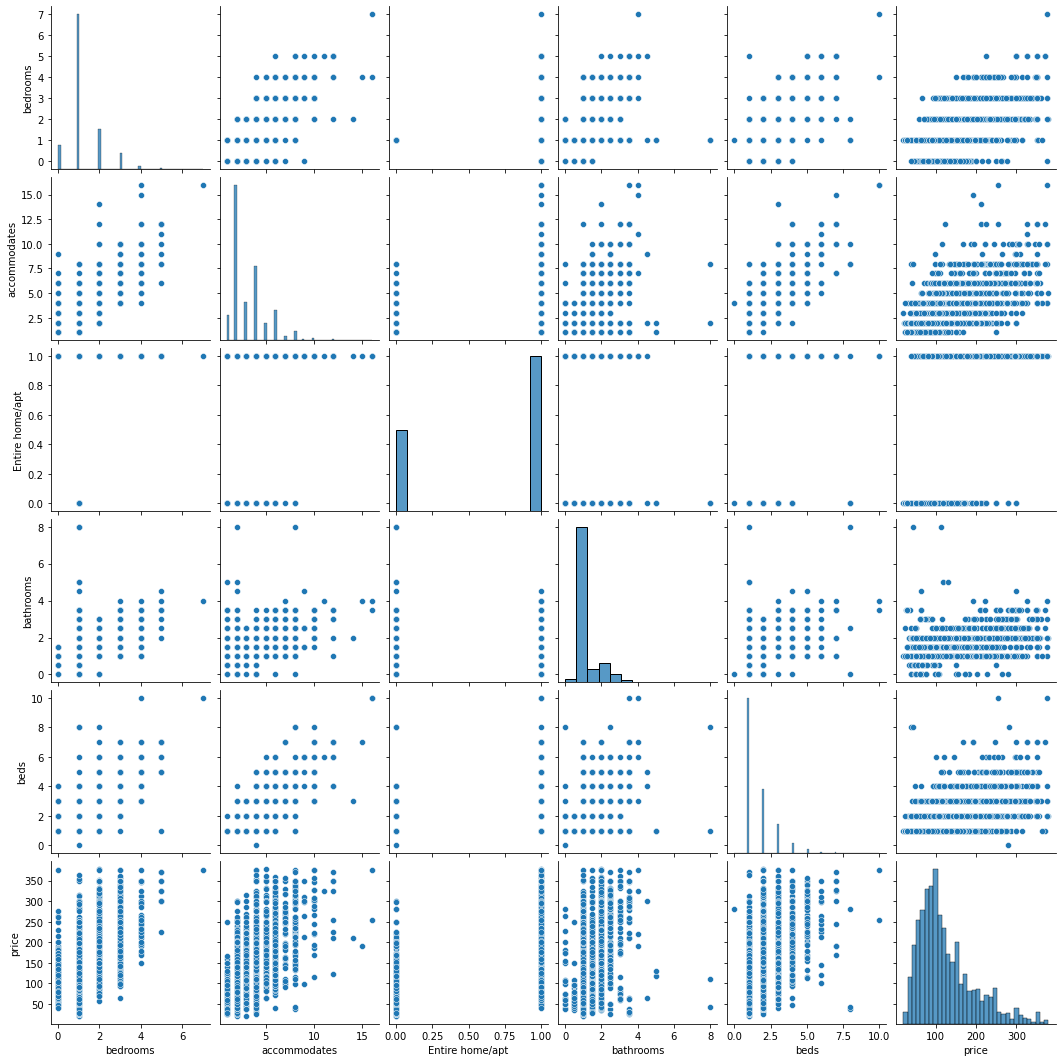

In [21]:
# Display the scatterplot matrix for the top 5 features with price
sb.pairplot(top_features_df)
plt.show()

The top 5 features are positively correlated with price to different degrees. However, we can say that many of them convery the same kind of information

## 4. Conclusion
In this exercise we analyzed the data from Airbnb Seattle dataset. We tried to answer the different posed business questions following CRISP-DM. 

We found that there's an overall increasing trend in listings availability. However, availability and prices are affected by holidays as expected, in addition to the changein weekends.

We also managed to build a predictive regression model to predict an expected average price for a listing from the listing features. This could be used as a tool to assist hosts in thier pricing strategies. We found that the most determintal features are the place specifications, then comes location later.